# XGBoost example - Higgs boson 

In this notebook we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/) to classify Higgs boson signal from background events and compare the performance of this model against similar ones. The dataset is taken from [Kaggle Higgs Boson Challenge](https://www.kaggle.com/c/higgs-boson/) from the [HiggsML challenge](https://higgsml.lal.in2p3.fr/) and is a modified version of the [HIGGS dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS) from the UCI repository. The dataset consists of 250'000 events.

In this example it'll be clear that the XGBoost model is really fast and efficient, since it can train on the full dataset in a few seconds.

In [1]:
# First of all lets import the libraries we need
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [2]:
# Now lets load the data
df = pd.read_csv('data/higgs-boson/training.zip', compression='zip')

# Lets see what we have
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [3]:
df.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

Some details to get started:

- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by  the physicists of ATLAS
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables

In [4]:
# Lets see the shape of the data
print(df.shape)

# Lets see the data info
df.info()

(250000, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null 

In [5]:
# mapping "-999.0" to NaN
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.nan if x == -999.0 else x)

In [6]:
df.isnull().sum()

EventId                             0
DER_mass_MMC                    38114
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           177457
DER_mass_jet_jet               177457
DER_prodeta_jet_jet            177457
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         177457
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt              99913
PRI_jet_leading_eta             99913
PRI_jet_lead

In [7]:
df.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,211886.000000,250000.000000,250000.000000,250000.000000,72543.000000,72543.000000,72543.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,150087.000000,150087.000000,150087.000000,72543.000000,72543.000000,72543.000000,250000.000000,250000.000000
mean,224999.500000,121.858528,49.239819,81.181982,57.895962,2.403735,371.783360,-0.821688,2.373100,18.917332,...,209.797178,0.979176,84.822105,-0.003275,-0.012393,57.679474,-0.011845,-0.001582,73.064591,1.646767
std,72168.927986,57.298157,35.344886,40.828691,63.655682,1.742226,397.699325,3.584362,0.782911,22.273494,...,126.499506,0.977426,60.662276,1.784546,1.813385,31.985782,2.031743,1.816950,98.015662,1.875103
min,100000.000000,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,...,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000,0.001502
25%,162499.750000,91.885250,19.241000,59.388750,14.068750,0.882500,111.977000,-2.629000,1.810000,2.841000,...,123.017500,0.000000,44.422500,-1.342000,-1.584000,37.312000,-1.612000,-1.576500,-0.000000,0.018636
50%,224999.500000,112.406000,46.524000,73.752000,38.467500,2.107000,225.885000,-0.244000,2.491500,12.315500,...,179.739000,1.000000,65.561000,0.000000,-0.033000,47.902000,-0.010000,-0.002000,40.512500,1.156188
75%,287499.250000,135.482000,73.598000,92.259000,79.169000,3.690000,478.226000,0.958000,2.961000,27.591000,...,263.379250,2.000000,103.342000,1.336000,1.562000,66.637000,1.589500,1.576000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [8]:
df['Label'] = (df['Label'] == 's').apply(float)  # MAYBE USE LABEL ENCODER INSTEAD
df = df.iloc[:, 1:]

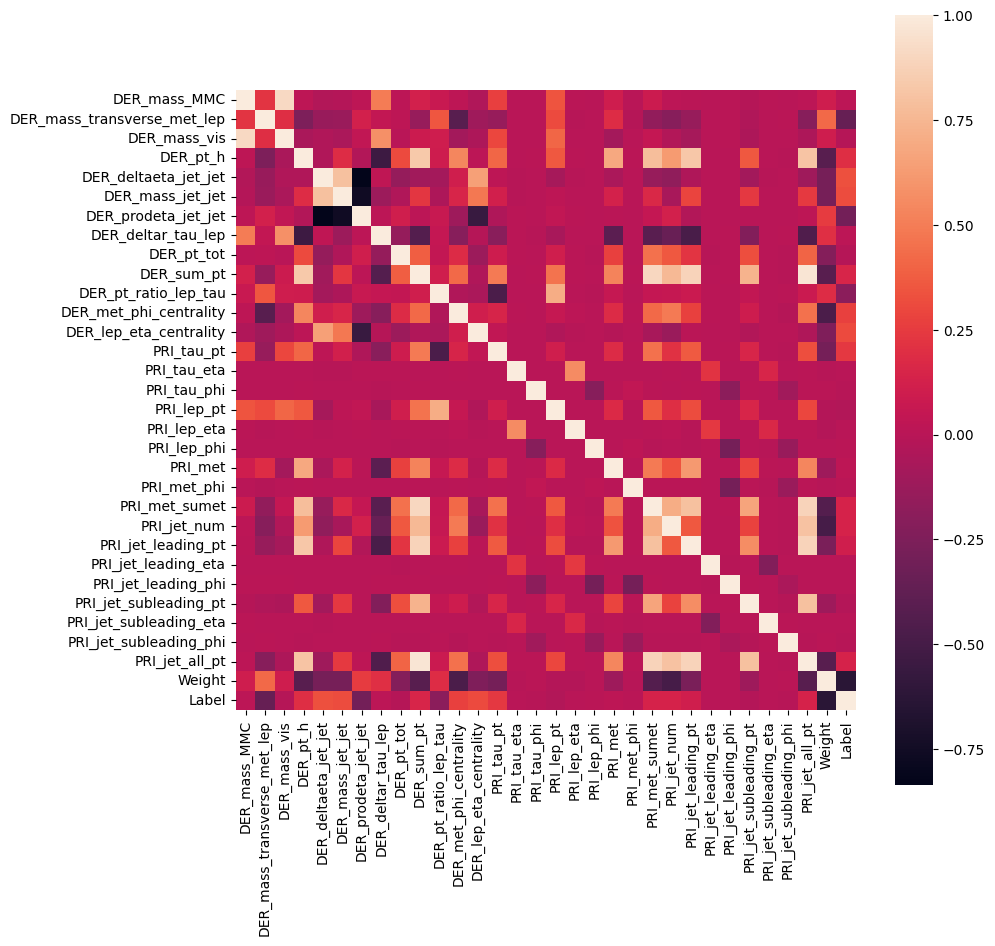

In [9]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=1, square=True)
plt.show()

In [10]:
# displaying the labels and their percentages
print(df['Label'].value_counts())
print('-'*35)
print(df['Label'].value_counts(normalize=True))

Label
0.0    164333
1.0     85667
Name: count, dtype: int64
-----------------------------------
Label
0.0    0.657332
1.0    0.342668
Name: proportion, dtype: float64


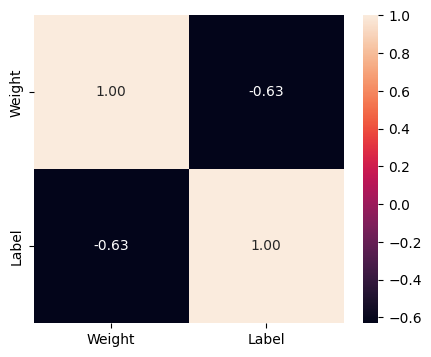

In [11]:
df.iloc[:, -2:].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(df.iloc[:, -2:].corr(), annot=True, fmt=".2f")
plt.show()

In [12]:
X = df.drop(['Weight', 'Label'], axis=1)
y = df['Label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

## Dataset preparation

In [14]:
# Since normally model don't work well with missing values, we will replace them with the mean of the column
X_train_imputed = X_train.fillna(X_train.mean())
X_test_imputed = X_test.fillna(X_test.mean())
# But we will also create a copy of the data without the imputation
X_train_no_imputed = X_train.copy()

# We Could also scale the data, but it is not necessary for tree based models
# scaler = StandardScaler()
# X_train_imputed_scaled = scaler.fit_transform(X_train_imputed)
# X_test_imputed_scaled = scaler.transform(X_test_imputed)

# X_train_no_imputed_scaled = scaler.fit_transform(X_train_no_imputed)
# X_test_no_imputed_scaled = scaler.transform(X_test_imputed)

## Decision tree

In [15]:
# simple decision tree classifier
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=21)
dt_clf.fit(X_train_imputed, y_train)
y_pred = dt_clf.predict(X_test_imputed)
print("Accuracy score using Decision Tree Classifier: ", accuracy_score(y_test, y_pred))
print("ROC AUC score using Decision Tree Classifier: ", roc_auc_score(y_test, y_pred))

Accuracy score using Decision Tree Classifier:  0.8102
ROC AUC score using Decision Tree Classifier:  0.7857961620478158


## Random forest

In [16]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=21)
rf_clf.fit(X_train_imputed, y_train)
y_pred = rf_clf.predict(X_test_imputed)
print("Accuracy score using Random Forest Classifier: ", accuracy_score(y_test, y_pred))
print("ROC AUC score using Random Forest Classifier: ", roc_auc_score(y_test, y_pred))

Accuracy score using Random Forest Classifier:  0.81058
ROC AUC score using Random Forest Classifier:  0.7610911112494081


## AdaBoost

In [17]:
# # imprting adaboost classifier
# from sklearn.ensemble import AdaBoostClassifier
# # now lets use the AdaBoost Classifier
# ada_clf = AdaBoostClassifier(n_estimators=200, random_state=21)
# ada_clf.fit(X_train, y_train)
# y_pred = ada_clf.predict(X_test)
# print("Accuracy score using AdaBoost Classifier: ", accuracy_score(y_test, y_pred))
# print("ROC AUC score using AdaBoost Classifier: ", roc_auc_score(y_test, y_pred))

In [18]:
ada_clf = AdaBoostClassifier(n_estimators=200, random_state=21)
ada_clf.fit(X_train_imputed, y_train)
y_pred = ada_clf.predict(X_test_imputed)
print("Accuracy score using AdaBoost Classifier: ", accuracy_score(y_test, y_pred))
print("ROC AUC score using AdaBoost Classifier: ", roc_auc_score(y_test, y_pred))

Accuracy score using AdaBoost Classifier:  0.81372
ROC AUC score using AdaBoost Classifier:  0.7684825938260357


## XGBoost

In [19]:
# # Using XGBoost Classifier
# xgb_clf = xgb.XGBClassifier(n_estimators=200, 
#                             max_depth=5,
#                             learning_rate=0.1,
#                             subsample=0.5,
#                             # colsample_bytree=0.5,
#                             gamma=5,
#                             n_jobs=-1, random_state=21)
# xgb_clf.fit(X_train, y_train)
# y_pred = xgb_clf.predict(X_test)
# print("Accuracy score using XGBoost Classifier: ", accuracy_score(y_test, y_pred))
# print("ROC AUC score using XGBoost Classifier: ", roc_auc_score(y_test, y_pred))

In [20]:

# rescale weight to make it same as test set
weight = dtrain[:,31] * float(test_size) / len(label)
# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
xgmat = xgb.DMatrix(data, label=label, missing = -999.0, weight=weight )

# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logitraw'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.1
param['max_depth'] = 6
param['eval_metric'] = 'auc'
param['nthread'] = 16

num_round = 120
xgb.train(param, xgmat, num_round)

NameError: name 'dtrain' is not defined

In [21]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=5, random_state=21)
xgb_clf.fit(X_train_imputed, y_train)
y_pred = xgb_clf.predict(X_test_imputed)
print("Imputed Accuracy score using XGBoost Classifier: ", accuracy_score(y_test, y_pred))
print("Imputed ROC AUC score using XGBoost Classifier: ", roc_auc_score(y_test, y_pred))

xgb_clf2 = XGBClassifier(n_estimators=200, max_depth=5, random_state=21)
xgb_clf2.fit(X_train_no_imputed, y_train)
y_pred = xgb_clf2.predict(X_test_no_imputed)
print("Not Imputed Accuracy score using XGBoost Classifier: ", accuracy_score(y_test, y_pred))
print("Not Imputed ROC AUC score using XGBoost Classifier: ", roc_auc_score(y_test, y_pred))

Imputed Accuracy score using XGBoost Classifier:  0.83818
Imputed ROC AUC score using XGBoost Classifier:  0.8068527806279353
Not Imputed Accuracy score using XGBoost Classifier:  0.83004
Not Imputed ROC AUC score using XGBoost Classifier:  0.7973408694514346


In [22]:
params = {'objective': 'binary:logistic', 'max_depth': 5, 'random_state':21}
xgb_dmatrix_imputed = xgb.DMatrix(data=X_train_imputed, label=y_train)
xgb_dmatrix_imputed_test = xgb.DMatrix(data=X_test_imputed, label=y_test)
xgb_clf3 = xgb.train(params=params, dtrain=xgb_dmatrix_imputed, num_boost_round=200)
xgb_clf3_pred = xgb_clf3.predict(xgb_dmatrix_imputed_test)
print("Imputed Accuracy score using XGBoost Classifier: ", accuracy_score(y_test, xgb_clf3_pred.round()))
print("Imputed ROC AUC score using XGBoost Classifier: ", roc_auc_score(y_test, xgb_clf3_pred))

xgb_dmatrix_no_imputed = xgb.DMatrix(data=X_train_no_imputed, label=y_train)
xgb_dmatrix_no_imputed_test = xgb.DMatrix(data=X_test_no_imputed, label=y_test)
xgb_clf4 = xgb.train(params=params, dtrain=xgb_dmatrix_no_imputed, num_boost_round=200)
xgb_clf4_pred = xgb_clf4.predict(xgb_dmatrix_no_imputed_test)
print("Not Imputed Accuracy score using XGBoost Classifier: ", accuracy_score(y_test, xgb_clf4_pred.round()))
print("Not Imputed ROC AUC score using XGBoost Classifier: ", roc_auc_score(y_test, xgb_clf4_pred))

Imputed Accuracy score using XGBoost Classifier:  0.83818
Imputed ROC AUC score using XGBoost Classifier:  0.9071297077910278
Not Imputed Accuracy score using XGBoost Classifier:  0.83004
Not Imputed ROC AUC score using XGBoost Classifier:  0.8952327740996117


## LightGBM

In [23]:
# importing lightgbm
import lightgbm as lgb

# creating the dataset
lgb_train = lgb.Dataset(data=X_train_imputed, label=y_train)
lgb_test = lgb.Dataset(data=X_test_imputed, label=y_test)

# defining the parameters
lgb_params = {'objective': 'binary', 'random_state': 21, 'metric': 'auc'}

# training the model
lgb_clf = lgb.train(params=lgb_params, train_set=lgb_train, num_boost_round=200)

# predicting on the test set
lgb_clf_pred = lgb_clf.predict(X_test_imputed)

# calculating the accuracy
print("Accuracy score using LightGBM Classifier: ", accuracy_score(y_test, lgb_clf_pred.round()))
print("ROC AUC score using LightGBM Classifier: ", roc_auc_score(y_test, lgb_clf_pred))

[LightGBM] [Info] Number of positive: 68477, number of negative: 131523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7358
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342385 -> initscore=-0.652684
[LightGBM] [Info] Start training from score -0.652684
Accuracy score using LightGBM Classifier:  0.83894
ROC AUC score using LightGBM Classifier:  0.9084002291473516
